In [25]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import metrics
%matplotlib inline

# Set some display settings.
sns.set(context='notebook')

In [2]:
def show_coefficients(model, feature_names):
    '''
    Show the coeffients and intercept of a linear model in a nice format.
    
    model: a LinearRegression object
    feature_names: a sequence of column names (e.g., train_X.columns)
    '''
    coefs_with_intercept = np.r_[[model.intercept_], model.coef_]
    feature_names_with_intercept = ["intercept"] + list(feature_names)
    display(
        pd.Series(coefs_with_intercept, index=feature_names_with_intercept)
        .to_frame('coefficient')
        .rename_axis(index="feature")
        .style.bar(align='mid'))

# Setup

We started working with the Capital Bike Share dataset in Homework 2 and 4. In this exercise we will use *multiple features* and *feature engineering* to dramatically improve our prediction performance. But as we saw in Lab 5, these tools also run the risk of *overfitting*, so be careful...

As before, our basic goal will be to try to predict ridership in 2012 based on ridership data in 2011. So the 2011 data will be our *training set* and the 2012 data will be our *test set* (aka *held-out* data or sometimes *validation* data).

First, we'll load up the data.

In [3]:
hourly_counts_orig = pd.read_csv('data/hour.csv')
print(len(hourly_counts_orig), "observations")
hourly_counts_orig.head()

17379 observations


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Renaming
Some of those column names are pretty awful. Let's fix a few of them up.

In [4]:
hourly_counts = hourly_counts_orig.rename(columns={
    'dteday': 'date',
    'hr': "hour",
    'mnth': "month",
    'weekday': "day_of_week",
    'holiday': "is_holiday",
    'workingday': "is_workingday",

    'weathersit': "precip_type",
    "hum": "humidity",
    'cnt': "rides"
}).drop(["instant", "casual", "registered"], axis=1)
hourly_counts['day_of_year'] = pd.to_datetime(hourly_counts['date']).dt.dayofyear

# Rearrange the column order
hourly_counts = hourly_counts[['date', 'day_of_year', 'season', 'yr', 'day_of_week', 'month',
       'hour', 'is_holiday', 'is_workingday', 'precip_type', 'temp', 'atemp',
       'humidity', 'windspeed', 'rides']]
hourly_counts.head()

,date,day_of_year,season,yr,day_of_week,month,hour,is_holiday,is_workingday,precip_type,temp,atemp,humidity,windspeed,rides
0,2011-01-01,1,1,0,6,1,0,0,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,1,0,6,1,1,0,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,1,0,6,1,2,0,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,1,0,6,1,3,0,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,1,0,6,1,4,0,0,1,0.24,0.2879,0.75,0.0,1


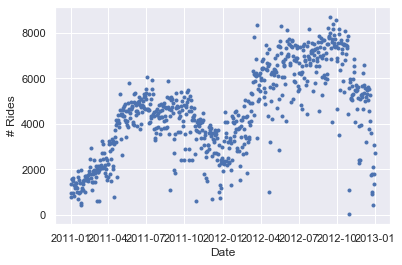

In [5]:
plt.plot(
    hourly_counts.groupby(
        pd.to_datetime(hourly_counts['date'])
    ).rides.sum(),
    '.')
plt.xlabel("Date")
plt.ylabel("# Rides");

# HACK!
Since the bike share program was overall more popular in 2012 than in 2011, predicting based on 2011 data will systematically under-predict ridership in 2012. More advanced modeling and validation techniques can handle this shift directly, but for now we'll do this little hack to make our current tools work. (Only do this in real life if you have a *really* good explanation for why, and be *totally* transparent about it if you do.)

First, we notice that there were many more rides in 2012 than in 2011.

In [6]:
hourly_counts.groupby('yr').rides.sum()

yr
0    1243103
1    2049576
Name: rides, dtype: int64

To make things comparable, let's normalize by popularity. Of course we wouldn't actually *know* the total popularity of 2012 during that year, which is why this particular approach is labeled "HACK!".

In [7]:
year_counts = hourly_counts.groupby('yr').rides.sum()
ratio = year_counts[1] / year_counts[0]
print("Scaling test set by", ratio)

hourly_counts['rides'] = np.where(hourly_counts.yr == 0, hourly_counts.rides, hourly_counts.rides / ratio)
print("New ridership totals by year:", hourly_counts.groupby('yr').rides.sum())

Scaling test set by 1.6487579870694544
New ridership totals by year: yr
0    1243103.0
1    1243103.0
Name: rides, dtype: float64


## Train-Test Split
We're going to use 2011 as the training set and 2012 as the test set.

In [8]:
train = hourly_counts[hourly_counts.yr == 0]
test = hourly_counts[hourly_counts.yr == 1]

In [9]:
assert train['date'].iloc[0] == '2011-01-01'
assert test['date'].iloc[0] == '2012-01-01'
assert all(train['date'].str.startswith('2011'))
assert all(test['date'].str.startswith('2012'))
assert len(train) + len(test) == len(hourly_counts)

In [10]:
train.drop(["yr"], axis=1).head()

,date,day_of_year,season,day_of_week,month,hour,is_holiday,is_workingday,precip_type,temp,atemp,humidity,windspeed,rides
0,2011-01-01,1,1,6,1,0,0,0,1,0.24,0.2879,0.81,0.0,16.0
1,2011-01-01,1,1,6,1,1,0,0,1,0.22,0.2727,0.80,0.0,40.0
2,2011-01-01,1,1,6,1,2,0,0,1,0.22,0.2727,0.80,0.0,32.0
3,2011-01-01,1,1,6,1,3,0,0,1,0.24,0.2879,0.75,0.0,13.0
4,2011-01-01,1,1,6,1,4,0,0,1,0.24,0.2879,0.75,0.0,1.0


# A Single Feature

Does apparent temperature ("feels like") affect ridership? Let's make a quick plot (we did this already last homework)

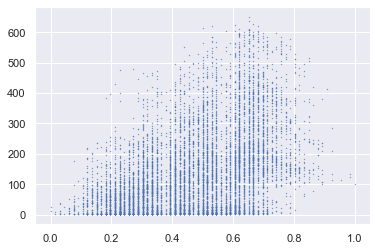

In [11]:
plt.scatter(train['atemp'], train['rides'], s=.1)

In [12]:
def transform(data):
    X = data[['atemp']]
    y = data['rides']
    return X, y
train_X, train_y = transform(train)
test_X, test_y = transform(test)

In [13]:
temp_only_model = LinearRegression().fit(train_X, train_y)

In [14]:
temp_only_model.coef_

array([338.37707325])

In [15]:
def show_scores(train_y, train_y_pred, test_y, test_y_pred):
    print("Training set MSE={:.2f}, r2={:.3f}".format(
        metrics.mean_squared_error(train_y, train_y_pred),
        metrics.r2_score(train_y, train_y_pred)
    ))
    print("Test set MSE={:.2f}, r2={:.3f}".format(
        metrics.mean_squared_error(test_y, test_y_pred),
        metrics.r2_score(test_y, test_y_pred)
    ))

train_y_pred = temp_only_model.predict(train_X)
test_y_pred = temp_only_model.predict(test_X)
    
show_scores(train_y, train_y_pred, test_y, test_y_pred)

Training set MSE=14322.80, r2=0.200
Test set MSE=13604.77, r2=0.153


In [16]:
show_coefficients(temp_only_model, train_X.columns)

,coefficient
feature,
intercept,-14.9046
atemp,338.377


In [17]:
def try_model(model, transform, training_data, test_data, display_coefficients=True):
    '''
    Try training and evaluating `model` using transform function `transform`.
    
    You do NOT need to use a function like this in your replication code; you can copy and paste if you want.
    
    Either way, be careful that your code uses the variables you intend it to,
    rather than picking up variables left over from elsewhere.
    '''

    train_X, train_y = transform(training_data)
    test_X, test_y = transform(test_data)
    
    model.fit(train_X, train_y)
    
    if display_coefficients:
        # Models like KNeighborsRegressor don't have coefficients.
        show_coefficients(model, train_X.columns)
    show_scores(
        train_y, model.predict(train_X),
        test_y, model.predict(test_X))
    return model

In [18]:
temp_only_model = try_model(LinearRegression(), transform, training_data=train, test_data=test)

,coefficient
feature,
intercept,-14.9046
atemp,338.377


Training set MSE=14322.80, r2=0.200
Test set MSE=13604.77, r2=0.153


## Add in `month` as a continuous feature

In [19]:
def transform(data):
    X = data[['atemp', 'month']]
    y = data['rides']
    return X, y
temp_and_month_model = try_model(LinearRegression(), transform, training_data=train, test_data=test)


,coefficient
feature,
intercept,-24.8087
atemp,325.583
month,2.41935


Training set MSE=14259.13, r2=0.203
Test set MSE=13567.19, r2=0.155


# One-hot encode `month`

Instead of using `month` as a continuous variable, let's use a one-hot encoding.

First, we notice that there are 12 unique values of `month`, as we'd expect:

In [20]:
months = sorted(set(train['month']))
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [21]:
def transform(data):
    X = data[['atemp']].copy()
    months_to_use = months[1:] # drop the first one, since it's redundant in this kind of model
    for month in months_to_use:
        X[f'month_{month}'] = 1.0 * (data['month'] == month)
    y = data['rides']
    return X, y

temp_and_month_model = try_model(LinearRegression(), transform, training_data=train, test_data=test)

,coefficient
feature,
intercept,-49.0975
atemp,513.378
month_2,-23.2985
month_3,-29.9554
month_4,-53.3761
month_5,-51.1229
month_6,-83.5096
month_7,-125.765
month_8,-100.507


Training set MSE=13795.07, r2=0.229
Test set MSE=13098.41, r2=0.184


# If a column per month is better, how about one for each day?

Encouraged by the increase in performance we saw on both the training and test sets when we added a one-hot encoding for each month, let's try one-hot encoding each day.

In [22]:
dates = sorted(set(train['date']))

In [23]:
def transform(data):
    X = data[['atemp']].copy()
    dates_to_use = dates[1:] # drop the first one, since it's redundant.
    for date in dates_to_use:
        X[f'date_{date}'] = 1.0 * (data['date'] == date)
    y = data['rides']
    return X, y

try_model(LinearRegression(), transform, training_data=train, test_data=test)

,coefficient
feature,
intercept,-343.844
atemp,1058.47
date_2011-01-02,4.24831
date_2011-01-03,204.684
date_2011-01-04,187.233
date_2011-01-05,170.735
date_2011-01-06,166.826
date_2011-01-07,188.447
date_2011-01-08,212.062


Training set MSE=11268.52, r2=0.370
Test set MSE=30031.60, r2=-0.871


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Interaction between atemp and month
We're not actually using this in the hw, but I wanted you to see this kind of feature, which is actually very common. In this particular case it overfits, though :(

In [29]:
def transform(data):
    X = data[['atemp']].copy()

    X['atemp^2'] = X['atemp'] ** 2

    months_to_use = months[1:] # drop the first one, since it's redundant.
    for month in months_to_use:
        X[f'month_{month}'] = (data['month'] == month).astype(float)
        X[f'atemp*month_{month}'] = data['atemp'] * (data['month'] == month)

    y = data['rides']
    return X, y
try_model(LinearRegression(), transform, training_data=train, test_data=test)

,coefficient
feature,
intercept,23.0289
atemp,216.765
atemp^2,-245.894
month_2,-27.0652
atemp*month_2,137.62
month_3,-64.3944
atemp*month_3,267.369
month_4,-181.791
atemp*month_4,538.41


Training set MSE=13287.29, r2=0.258
Test set MSE=13639.77, r2=0.150


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

But Ridge regularization helps a lot with the overfitting.

In [36]:
def transform(data):
    X = data[['atemp']].copy()

    X['atemp^2'] = X['atemp'] ** 2

    months_to_use = months[1:] # drop the first one, since it's redundant.
    for month in months_to_use:
        X[f'month_{month}'] = (data['month'] == month).astype(float)
        X[f'atemp*month_{month}'] = data['atemp'] * (data['month'] == month)

    y = data['rides']
    return X, y
try_model(Ridge(alpha=5.), transform, training_data=train, test_data=test)

,coefficient
feature,
intercept,3.18742
atemp,162.567
atemp^2,339.313
month_2,24.3809
atemp*month_2,-110.446
month_3,9.62958
atemp*month_3,-51.8968
month_4,-32.9175
atemp*month_4,28.448


Training set MSE=13457.59, r2=0.248
Test set MSE=12963.37, r2=0.192


Ridge(alpha=5.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)